# Dependencies

In [1]:
import argparse

import os

import time
import torch

import matplotlib.pyplot as plt
import numpy as np

from model.dataloader import HELMETDataLoader
from model.dataloader import class_dict
from model.models import Darknet, load_weights, load_darknet_weights
from utils.utils import *

from IPython.display import clear_output

# Load in model

In [2]:
cfg_path = './cfg/yolov3_36.cfg'
conv74_weights_path = './weights/darknet53.conv.74'
trained_weights_path = './weights/trained_models/416e17.pt'

In [3]:
# Load in darknet.
def get_darknet(img_size, cfg=cfg_path):
    return Darknet(cfg, img_size)

img_size = 416

model = get_darknet(img_size=img_size)

In [4]:
# load in weights
# load_weights(model, trained_weights_path) # load_darknet_weights(model, conv74_weights_path)
checkpoint = torch.load(trained_weights_path, map_location='cpu')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [5]:
cuda_enable = False
cuda_available = torch.cuda.is_available()
if cuda_enable and cuda_available:
    device = torch.device('cuda:0')
else:
    device = 'cpu'

# Dataloader

In [6]:
batch_size = 3

dataloader = HELMETDataLoader("./data/HELMET_DATASET_DUMMY", shuffle=True, batch_size=batch_size, resize=(img_size, img_size))

# Dataloader unit test

In [7]:
batch = next(iter(dataloader))

imgs, targets, annotations = batch

# imgs = imgs[0].reshape(1, 3, img_size, img_size)

out = model(imgs)

print('Img shape:', imgs.shape)
print('Output shape:', out.shape)
print('Targets shape:', targets[0].size())

Img shape: torch.Size([3, 3, 416, 416])
Output shape: torch.Size([3, 10647, 41])
Targets shape: torch.Size([6, 5])


In [8]:
model.to(device).eval()
targets = list(map(lambda x: x.type(torch.FloatTensor), targets))
model(imgs, targets)
# model.losses

C:\Users\runes\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


tensor(44.08669, grad_fn=<AddBackward0>)

# Test the model

### Detection hyperparamaters

In [9]:
opt = {
    'conf_thres': .5,  # Confidence threshold.
    'nms_thres': .45   # Non-max supression.
}

### Make predictions

In [10]:
model.to(device).eval()
img_detections = []

# Get detections
for img in imgs:
    with torch.no_grad():
        pred = model(img.reshape(1, 3, img_size, img_size)) # pred = model(chip)
        pred = pred[pred[:, :, 4] > opt['conf_thres']]

        if len(pred) > 0:
            detections = non_max_suppression(pred.unsqueeze(0), opt['conf_thres'], opt['nms_thres'])
            img_detections.extend(detections)

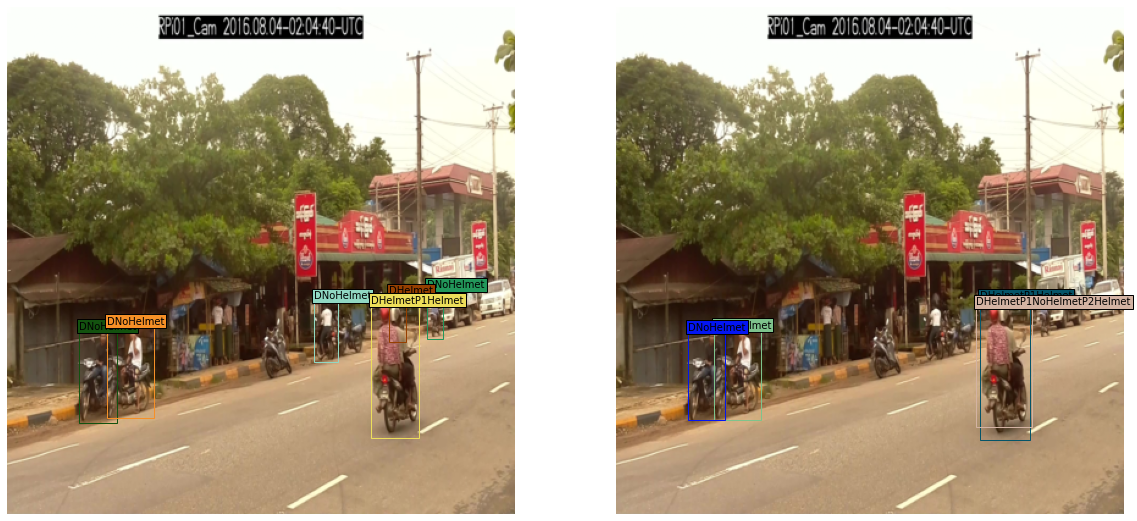

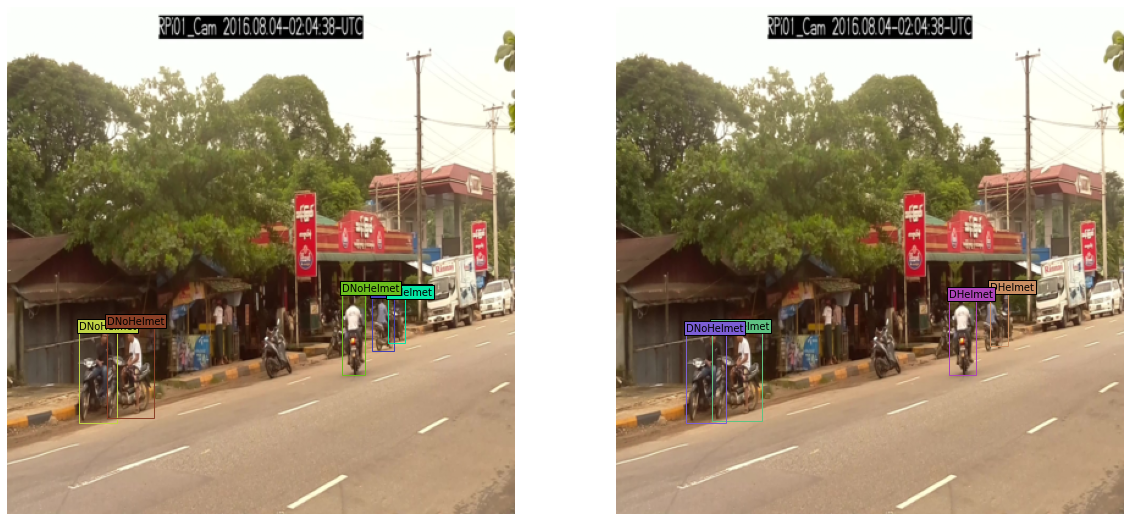

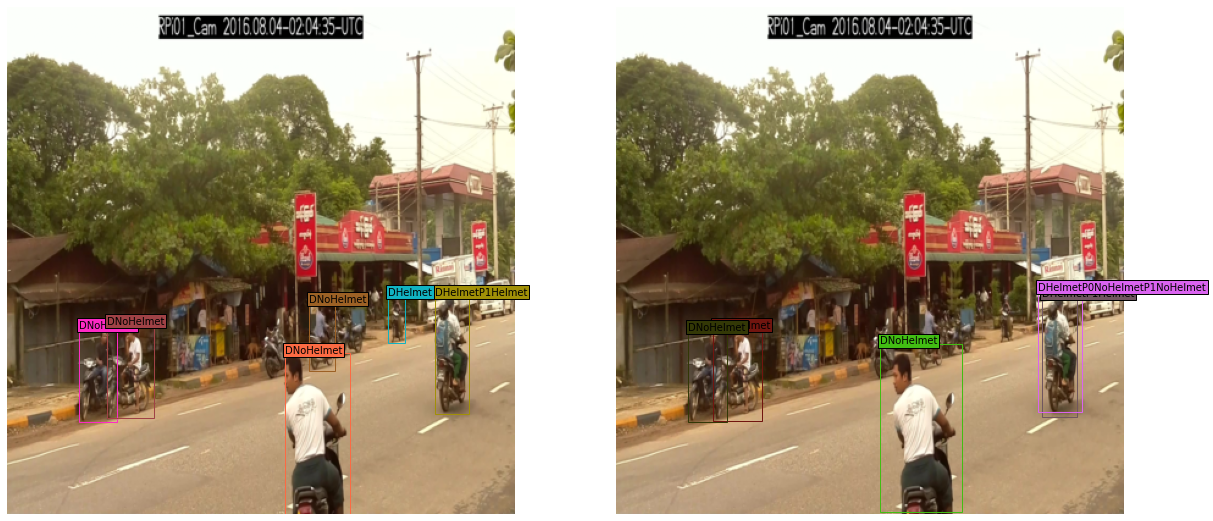

In [11]:
# detection = img_detectionn
# target = targets

for img, target, detection in zip(imgs, targets, img_detections):
    ### This is probably redundant in our case.
    # The amount of padding that was added
    pad_x = max(img.shape[1] - img.shape[2], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[2] - img.shape[1], 0) * (img_size / max(img.shape))
    # Image height and width after padding is removed
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.imshow(np.array(img).transpose([1, 2, 0]))
    ax2.imshow(np.array(img).transpose([1, 2, 0]))
    ax1.axis('off')
    ax2.axis('off')

    for label, x1, y1, box_w, box_h in target:
        # Rescale coordinates to original dimensions
        box_h = (box_h * img.shape[1]).item()
        box_w = (box_w * img.shape[2]).item()
        y1 = (y1 * img.shape[1] - box_h / 2).round().item()
        x1 = (x1 * img.shape[2] - box_w / 2).round().item()

        x1, y1 = max(x1, 0), max(y1, 0)

        label = list(class_dict.keys())[int(label)]
        col = tuple(np.random.random(3))
        rect = plt.Rectangle((x1, y1), box_w, box_h, fc="none", ec=col)
        ax1.add_patch(rect)
        ax1.text(x1, y1, label, fontsize=10, bbox={'facecolor': col, 'pad': 2})



    # Draw bounding boxes and labels of detections
    if detection is not None:
        unique_classes = detection[:, -1].cpu().unique()

        for i in unique_classes:
            n = (detection[:, -1].cpu() == i).sum()
            # print('%g %ss' % (n, classes[int(i)]))

        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detection:
            if len(class_dict.keys()) < int(cls_pred) - 1:
                continue

            # Rescale coordinates to original dimensions
            box_h = ((y2 - y1) / unpad_h) * img.shape[1]
            box_w = ((x2 - x1) / unpad_w) * img.shape[2]
            y1 = (((y1 - pad_y // 2) / unpad_h) * img.shape[1]).round().item()
            x1 = (((x1 - pad_x // 2) / unpad_w) * img.shape[2]).round().item()

            label = list(class_dict.keys())[int(cls_pred)]
            col = tuple(np.random.random(3))
            rect = plt.Rectangle((x1, y1), box_w, box_h, fc="none", ec=col)
            ax2.add_patch(rect)
            ax2.text(x1, y1, label, fontsize=10, bbox={'facecolor': col, 'pad': 2})

    plt.show()